In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import mikkel_tools.GMT_tools as gt

# ChaosMagPy modules
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Swarm observations with tapered ensemble as prior"
nb_name = "nb_case_core_vires_swarm_obs"

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

core.condtab(normsize=10000, quantiles = 1000, 
             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"

# Covariance model

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


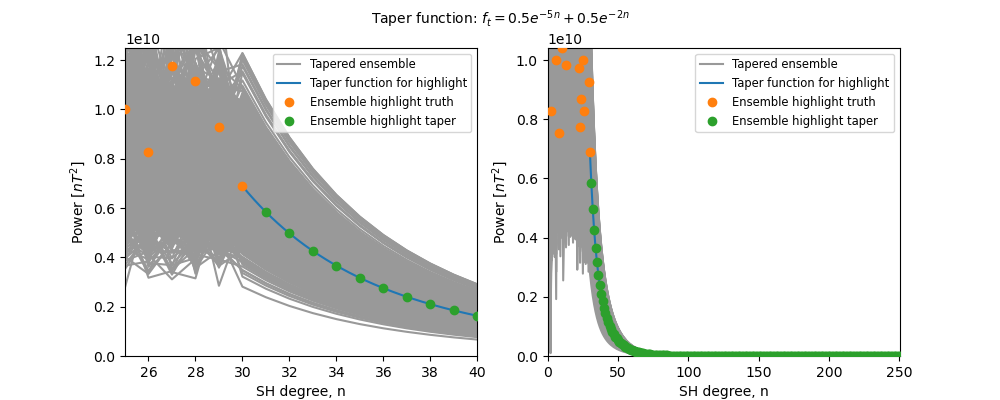

In [3]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True)

# Swarm observations through VirES VRE

In [4]:
import datetime as dt
from viresclient import SwarmRequest

request = SwarmRequest()

In [5]:
request.available_auxiliaries()

['Timestamp',
 'Latitude',
 'Longitude',
 'Radius',
 'Spacecraft',
 'OrbitDirection',
 'QDOrbitDirection',
 'SyncStatus',
 'Kp10',
 'Kp',
 'Dst',
 'F107',
 'IMF_BY_GSM',
 'IMF_BZ_GSM',
 'IMF_V',
 'F10_INDEX',
 'OrbitSource',
 'OrbitNumber',
 'AscendingNodeTime',
 'AscendingNodeLongitude',
 'QDLat',
 'QDLon',
 'QDBasis',
 'MLT',
 'SunDeclination',
 'SunHourAngle',
 'SunRightAscension',
 'SunAzimuthAngle',
 'SunZenithAngle',
 'SunLongitude',
 'SunVector',
 'DipoleAxisVector',
 'NGPLatitude',
 'NGPLongitude',
 'DipoleTiltAngle']

In [6]:
request.available_models(details=True)

AMPS = AMPS()
  START: 1900-01-01T00:00:00Z
  END:   2025-01-01T00:00:00Z
DESCRIPTION:
AMPS - associated magnetic field, https://github.com/klaundal/pyAMPS
SOURCES:
  SW_OPER_MIO_SHA_2E_00000000T000000_99999999T999999_0103

CHAOS = 'CHAOS-Core'(max_degree=20,min_degree=1) + 'CHAOS-Static'(max_degree=185,min_degree=21) + 'CHAOS-MMA-Primary'(max_degree=2,min_degree=1) + 'CHAOS-MMA-Secondary'(max_degree=2,min_degree=1)
  START: 2002-01-01T00:00:00Z
  END:   2020-11-27T23:30:00Z
DESCRIPTION:
Alias for 'CHAOS-Core' + 'CHAOS-Static' + 'CHAOS-MMA-Primary' + 'CHAOS-MMA-Secondary'
SOURCES:
  CHAOS-7_static.shc
  SW_OPER_MCO_SHA_2X_19970101T000000_20210131T235959_0704
  SW_OPER_MMA_CHAOS__20020101T000000_20021231T233000_0701
  SW_OPER_MMA_CHAOS__20030101T000000_20031231T233000_0701
  SW_OPER_MMA_CHAOS__20040101T000000_20041231T233000_0701
  SW_OPER_MMA_CHAOS__20050101T000000_20051231T233000_0701
  SW_OPER_MMA_CHAOS__20060101T000000_20061231T233000_0701
  SW_OPER_MMA_CHAOS__20070101T000000_200712

In [7]:
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]

use_models = ["LCS1='LCS-1'(min_degree=1, max_degree=185)", "CHAOS-MMA", "MIO_SHA_2C"] # "CHAOS='CHAOS-Core'(min_degree=15, max_degree=20)"

samp_step = "PT5M"

In [8]:
request.set_collection(collect)

request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step=samp_step)
                     #sampling_step="PT12M") # could be reduced

#date_start = [2018,8,1]
#date_end = [2019,8,1]
date_start = [2018,11,1]
date_end = [2019,11,1]
data = request.get_between(start_time=dt.datetime(date_start[0],date_start[1],date_start[2]),
                           end_time=dt.datetime(date_end[0],date_end[1],date_end[2])) # Above 3 months could lead to secular variation "error"

ds = data.as_xarray()

[1/1] Processing:  100%|██████████|  [ Elapsed: 03:31, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (17.92MB)


In [9]:
SZA_angle = 120
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0

dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)

idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))

In [10]:
obs_sat = SDSS(comment, N_SH = shc_g)

obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.lat)
print(obs_sat.grid_N)

4884


In [11]:
# chaosmagpy
N_chaos = 20
CHAOS7 = load_CHAOS_matfile('mikkel_tools/models_shc/CHAOS-7.mat')
# Start
chaos_time = mjd2000(date_start[0],date_start[1],date_start[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_start = np.matmul(A_r,g_CHAOS7)

M_use = ds["B_NEC_LCS1"].values[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA"].values[:,2][idx_sort] #+ ds["B_NEC_MIO_SHA_2C"].values[:,2][idx_sort]  

B_delta_SV =-ds["B_NEC"].values[:,2][idx_sort] + M_use - B_CHAOS7_start

In [12]:

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + M_use - B_delta_SV


<IPython.core.display.Javascript object>


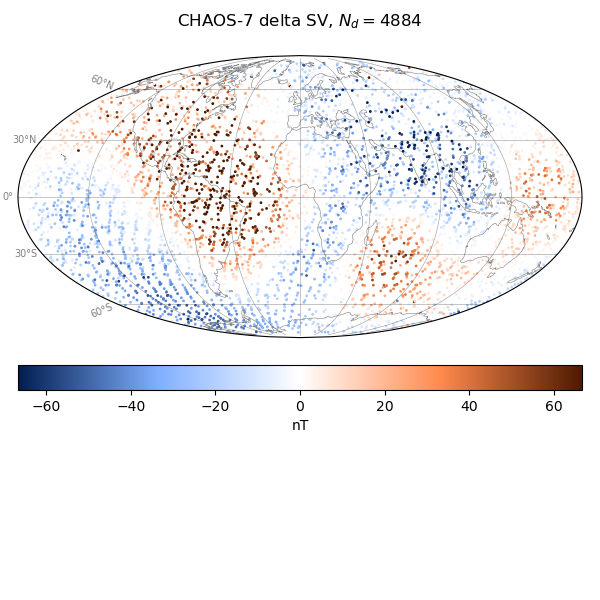

In [13]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=B_delta_SV, limits_data = [-100,100],
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 delta SV, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


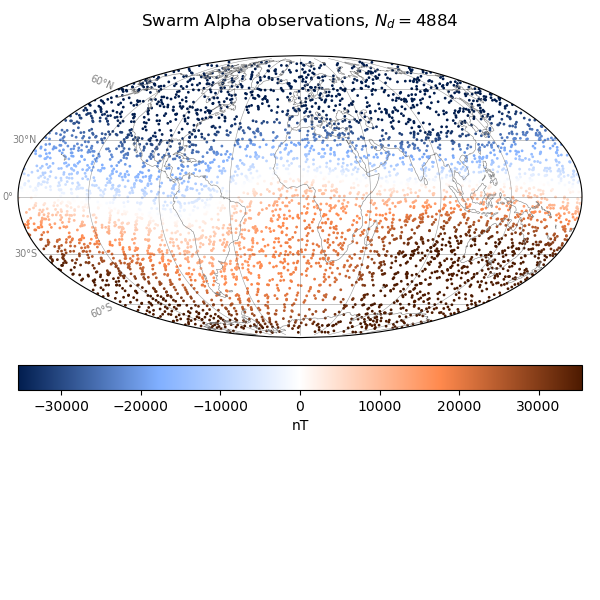

<IPython.core.display.Javascript object>


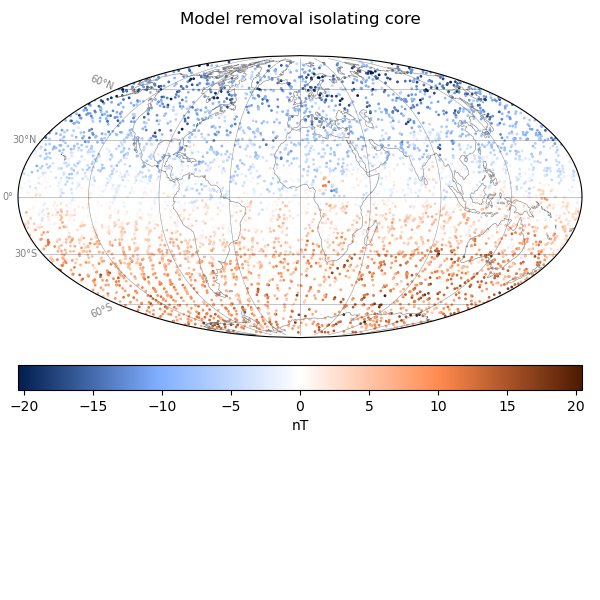

In [14]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm Alpha observations, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-M_use, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Model removal isolating core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

# System equations

In [15]:
C_e_const = 6
core.integrating_kernel(obs_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

# SDSSIM

In [ ]:
N_sim = 500
core.target_var = np.max(core.C_ens_tap)

core.run_sim(N_sim, core.grid_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.276 minutes 
Total elapsed time: 30.276 minutes 
Variance: 211952146234.955
Mean: 1227.674
Max: 1681917.592
Min: -1452355.140
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.668 minutes 
Total elapsed time: 59.945 minutes 
Variance: 214447428538.387
Mean: 2939.526
Max: 1649580.533
Min: -1445899.265
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.644 minutes 
Total elapsed time: 1.493 hours 
Variance: 215960305319.119
Mean: 2374.590
Max: 1500328.917
Min: -1539512.040
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.453 minutes 
Total elapsed time: 1.984 hours 
Variance: 207123049168.524
Mean: 4885.635
Max: 2536249.349
Min: -1756032.737
Run nr.: 4

 |OOOOOOOOOO| 100.0%   realization nr.

 |OOOOOOOOOO| 100.0%   realization nr. 34. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.007 minutes 
Total elapsed time: 17.439 hours 
Variance: 206300492214.697
Mean: 5775.064
Max: 1765123.002
Min: -1601263.890
Run nr.: 35

 |OOOOOOOOOO| 100.0%   realization nr. 35. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.239 minutes 
Total elapsed time: 17.943 hours 
Variance: 219410634763.848
Mean: 10039.049
Max: 1758073.205
Min: -1960287.035
Run nr.: 36

 |OOOOOOOOOO| 100.0%   realization nr. 36. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.953 minutes 
Total elapsed time: 18.442 hours 
Variance: 213950431618.030
Mean: 7612.517
Max: 1703330.761
Min: -1282553.585
Run nr.: 37

 |OOOOOOOOOO| 100.0%   realization nr. 37. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.189 minutes 
Total elapsed time: 18.945 hours 
Variance: 230714271474.457
Mean: 8741.635
Max: 2890237.585
Min: -1822918.639
Run nr.: 38

 |OOOOOOOOOO| 100.0%   realizat

 |OOOOOOOOOO| 100.0%   realization nr. 68. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.137 minutes 
Total elapsed time: 34.474 hours 
Variance: 209534933239.564
Mean: 2648.866
Max: 1516340.520
Min: -1636414.504
Run nr.: 69

 |OOOOOOOOOO| 100.0%   realization nr. 69. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.978 minutes 
Total elapsed time: 34.974 hours 
Variance: 215799536093.102
Mean: 2264.026
Max: 1938814.775
Min: -2473390.163
Run nr.: 70

 |OOOOOOOOOO| 100.0%   realization nr. 70. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.126 minutes 
Total elapsed time: 35.476 hours 
Variance: 218554468325.571
Mean: 8154.790
Max: 1806152.732
Min: -1528373.443
Run nr.: 71

 |OOOOOOOOOO| 100.0%   realization nr. 71. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.409 minutes 
Total elapsed time: 35.983 hours 
Variance: 231807627333.572
Mean: 5525.130
Max: 1634709.179
Min: -4737455.418
Run nr.: 72

 |OOOOOOOOOO| 100.0%   realizati

 |OOOOOOOOOO| 100.0%   realization nr. 102. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.664 minutes 
Total elapsed time: 51.464 hours 
Variance: 221059429032.613
Mean: 1985.967
Max: 1939513.889
Min: -1749658.513
Run nr.: 103

 |OOOOOOOOOO| 100.0%   realization nr. 103. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.944 minutes 
Total elapsed time: 51.963 hours 
Variance: 205505981871.314
Mean: 3556.033
Max: 2136911.683
Min: -1272774.394
Run nr.: 104

 |OOOOOOOOOO| 100.0%   realization nr. 104. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.761 minutes 
Total elapsed time: 52.459 hours 
Variance: 217258780238.410
Mean: 7354.933
Max: 1450518.097
Min: -1287988.951
Run nr.: 105

 |OOOOOOOOOO| 100.0%   realization nr. 105. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.931 minutes 
Total elapsed time: 52.958 hours 
Variance: 213588704395.879
Mean: 5171.688
Max: 1590084.637
Min: -1458459.247
Run nr.: 106

 |OOOOOOOOOO| 100.0%   r

 |OOOOOOOOOO| 100.0%   realization nr. 136. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.432 minutes 
Total elapsed time: 68.455 hours 
Variance: 223193701011.550
Mean: 8617.314
Max: 1593676.729
Min: -1522424.017
Run nr.: 137

 |OOOOOOOOOO| 100.0%   realization nr. 137. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.767 minutes 
Total elapsed time: 68.951 hours 
Variance: 231058329067.036
Mean: 5947.415
Max: 1639873.893
Min: -4137351.860
Run nr.: 138

 |OOOOOOOOOO| 100.0%   realization nr. 138. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.754 minutes 
Total elapsed time: 69.447 hours 
Variance: 220672399403.291
Mean: 4320.622
Max: 1706603.144
Min: -1517465.263
Run nr.: 139

 |OOOOOOOOOO| 100.0%   realization nr. 139. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.133 minutes 
Total elapsed time: 69.932 hours 
Variance: 215435198673.266
Mean: 4551.312
Max: 1784475.335
Min: -1622407.124
Run nr.: 140

 |OOOOOOOOOO| 100.0%   r

 |OOOOOOOOOO| 100.0%   realization nr. 170. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.782 minutes 
Total elapsed time: 85.600 hours 
Variance: 215824799140.202
Mean: 923.368
Max: 1729367.575
Min: -1643486.930
Run nr.: 171

 |OOOOOOOOOO| 100.0%   realization nr. 171. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 31.690 minutes 
Total elapsed time: 86.129 hours 
Variance: 208826234554.967
Mean: 9566.957
Max: 1783368.002
Min: -1530129.728
Run nr.: 172

 |OOOOOOOOOO| 100.0%   realization nr. 172. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 32.628 minutes 
Total elapsed time: 86.672 hours 
Variance: 220702252298.156
Mean: 3571.178
Max: 1737185.964
Min: -1425410.485
Run nr.: 173

 |OOOOOOOOOO| 100.0%   realization nr. 173. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 31.984 minutes 
Total elapsed time: 87.205 hours 
Variance: 228069246124.397
Mean: 3402.921
Max: 1826357.501
Min: -4545988.527
Run nr.: 174

 |OOOOOOOOOO| 100.0%   re

 |OOOOOOOOOO| 100.0%   realization nr. 204. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.716 minutes 
Total elapsed time: 102.950 hours 
Variance: 225225337971.117
Mean: -1878.075
Max: 1345095.220
Min: -1770973.610
Run nr.: 205

 |OOOOOOOOOO| 100.0%   realization nr. 205. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.433 minutes 
Total elapsed time: 103.441 hours 
Variance: 219646018402.034
Mean: 4308.324
Max: 1935599.023
Min: -1420993.109
Run nr.: 206

 |OOOOOOOOOO| 100.0%   realization nr. 206. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 30.003 minutes 
Total elapsed time: 103.941 hours 
Variance: 214075952721.419
Mean: 3383.314
Max: 1595954.334
Min: -1583194.362
Run nr.: 207

 |OOOOOOOOOO| 100.0%   realization nr. 207. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.836 minutes 
Total elapsed time: 104.438 hours 
Variance: 227475195790.694
Mean: 5677.283
Max: 1519092.124
Min: -4769110.951
Run nr.: 208

 |OOOOOOOOOO| 100.0

 |OOOOOOOOOO| 100.0%   realization nr. 238. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.268 minutes 
Total elapsed time: 119.794 hours 
Variance: 224369276228.451
Mean: 2536.228
Max: 1819390.907
Min: -4809739.049
Run nr.: 239

 |OOOOOOOOOO| 100.0%   realization nr. 239. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.301 minutes 
Total elapsed time: 120.282 hours 
Variance: 209889577583.566
Mean: 3237.385
Max: 1538103.083
Min: -1611133.360
Run nr.: 240

 |OOOOOOOOOO| 100.0%   realization nr. 240. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.325 minutes 
Total elapsed time: 120.771 hours 
Variance: 214870796647.245
Mean: 6622.600
Max: 1743966.213
Min: -1386264.634
Run nr.: 241

 |OOOOOOOOOO| 100.0%   realization nr. 241. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 28.995 minutes 
Total elapsed time: 121.254 hours 
Variance: 218989473410.016
Mean: 4800.331
Max: 1832881.606
Min: -2022738.274
Run nr.: 242

 |OOOOOOOOOO| 100.0%

 |OOOOOOOOOO| 100.0%   realization nr. 272. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.336 minutes 
Total elapsed time: 136.623 hours 
Variance: 217781234315.699
Mean: 2418.537
Max: 1790640.568
Min: -1534057.159
Run nr.: 273

 |OOOOOOOOOO| 100.0%   realization nr. 273. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.595 minutes 
Total elapsed time: 137.116 hours 
Variance: 212232434471.298
Mean: 5370.883
Max: 1724817.335
Min: -1600874.190
Run nr.: 274

 |OOOOOOOOOO| 100.0%   realization nr. 274. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.240 minutes 
Total elapsed time: 137.603 hours 
Variance: 207143547238.840
Mean: 4738.411
Max: 1412848.481
Min: -1574066.670
Run nr.: 275

 |OOOOOOOOOO| 100.0%   realization nr. 275. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.477 minutes 
Total elapsed time: 138.095 hours 
Variance: 227362683537.632
Mean: 1986.470
Max: 1839137.823
Min: -1658131.468
Run nr.: 276

 |OOOOOOOOOO| 100.0%

 |OOOOOOOOOO| 100.0%   realization nr. 306. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.609 minutes 
Total elapsed time: 153.272 hours 
Variance: 213607588968.777
Mean: 8172.285
Max: 1946859.559
Min: -1734132.543
Run nr.: 307

 |OOOOOOOOOO| 100.0%   realization nr. 307. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.528 minutes 
Total elapsed time: 153.764 hours 
Variance: 201032749384.140
Mean: 1909.417
Max: 1347815.839
Min: -1483477.964
Run nr.: 308

 |OOOOOOOOOO| 100.0%   realization nr. 308. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.177 minutes 
Total elapsed time: 154.250 hours 
Variance: 220565423701.728
Mean: 9638.674
Max: 1568433.515
Min: -1655405.225
Run nr.: 309

 |OOOOOOOOOO| 100.0%   realization nr. 309. Counter: 1891/1891, Running error magnitude: 5.5
Run time: 29.597 minutes 
Total elapsed time: 154.744 hours 
Variance: 221863976716.990
Mean: 3726.647
Max: 1645862.064
Min: -1699551.976
Run nr.: 310

 |OOOOOOOOOO| 100.0%

In [17]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shc_grid)

In [18]:
#core.covmod_lsq_equiv(s_sat.data, C_Br_model, core.G, core.r_cmb)

<IPython.core.display.Javascript object>


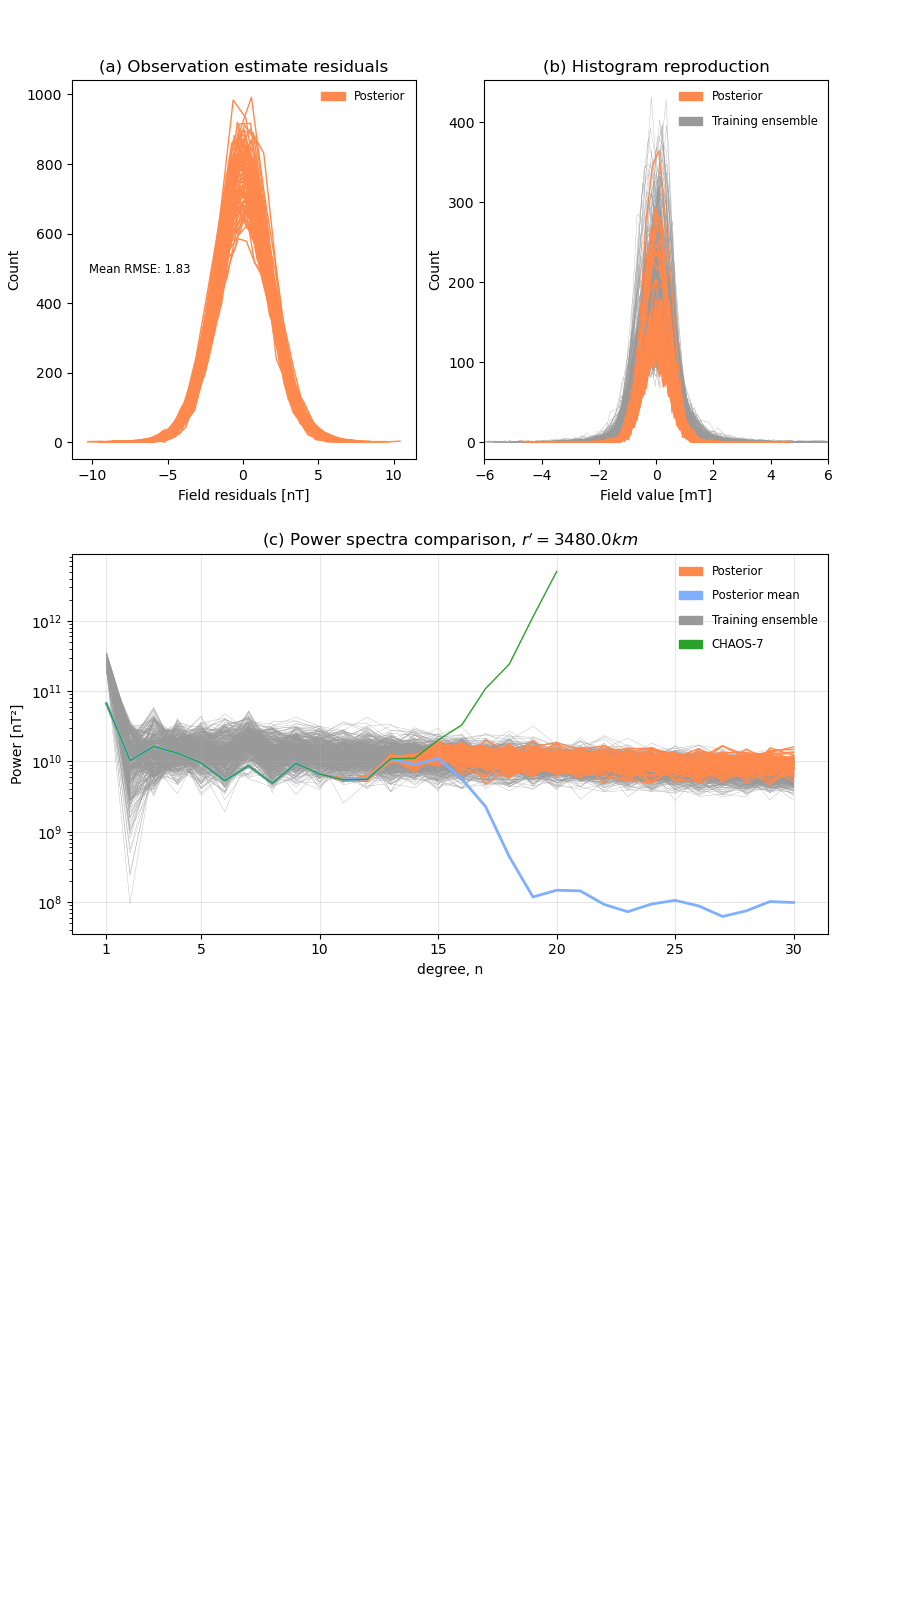

In [29]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = None, truth_obj = None,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 1.0, label_fontsize = "small", ens_prior = True,
                              model_dict = {"CHAOS-7"}, spec_chaos_time = date_start,
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, hist_ti_ens_limit = [-6,6],
                              figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_dpi = 300)

In [30]:
date_start_str = "Sy" + str(date_start).replace("[","").replace("]","").replace(" ", "m").replace(",","")
date_start_str = "d".join(date_start_str.rsplit("m", 1))
date_end_str = "Ey" + str(date_end).replace("[","").replace("]","").replace(" ", "m").replace(",","")
date_end_str = "d".join(date_end_str.rsplit("m", 1))

str_append = "_Ce{}_{}_{}_{}_Np{}".format(C_e_const,samp_step, date_start_str, date_end_str, N_sim)

core.pickle_save_self(nb_name, name_append = str_append)


Saving job

Job saved and finished


In [24]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


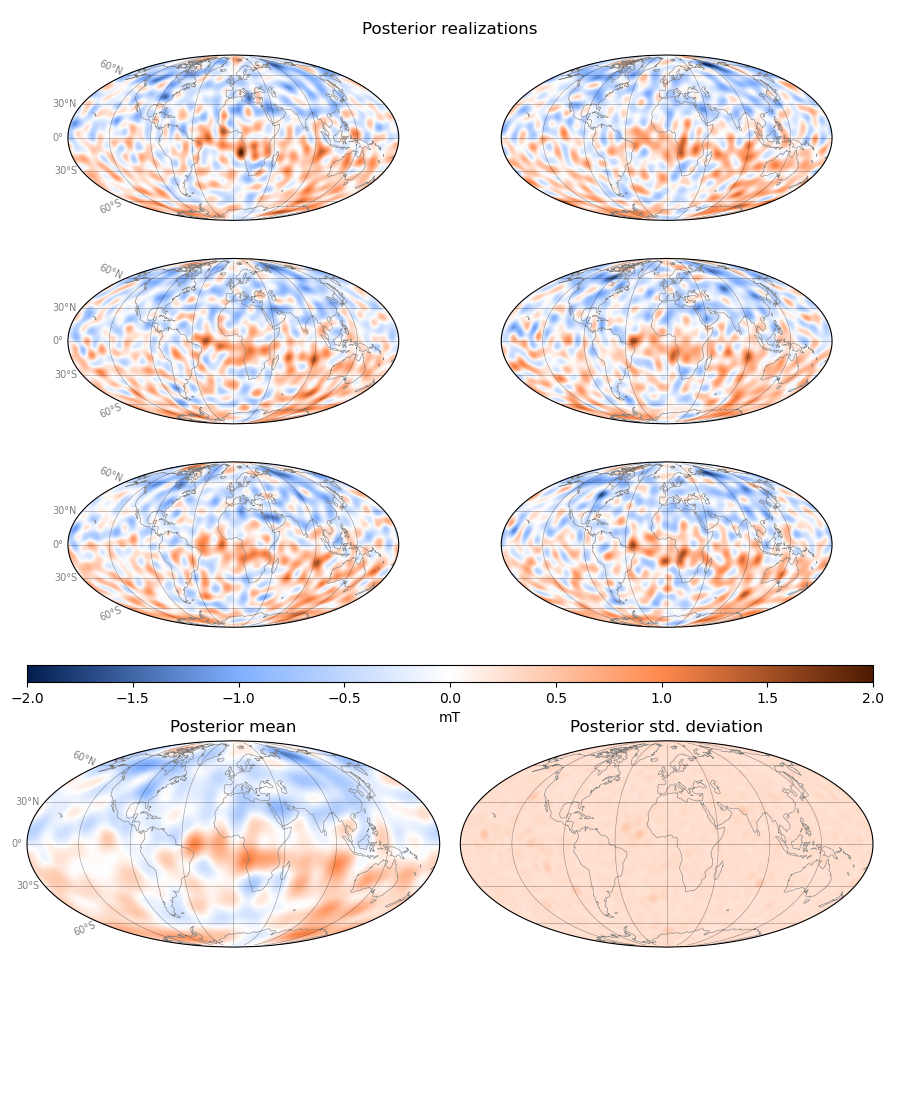

In [28]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,11), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_vires_swarm_obs", save_path = "images/",
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
